In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from math import *
from puwr import tauint, correlated_data
import h5py
from scipy.linalg import sqrtm as sqrtm
%matplotlib inline

In [5]:
f = h5py.File('gomos_normalised.mat')
A = np.array(f.get('A'))
C = np.array(f.get('C'))
RA = np.array(f.get('RA'))
RG = np.array(f.get('RG'))
Sigma = np.array(f.get('Sigma'))
Umean = np.array(f.get('Umean'))
Y = np.array(f.get('Y'))

<ipython-input-5-902f324dd046>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('gomos_normalised.mat')


In [6]:
Y.shape

(50, 1416)

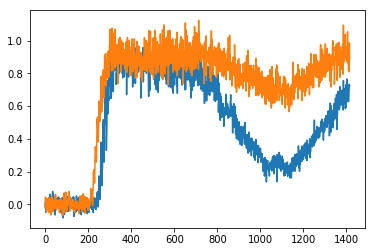

In [11]:
plt.plot(Y[0])
plt.plot(Y[10])

In [19]:
def forwardmodel(x):
    x = x.reshape((4,50))
    BT = np.exp(RG@x@RA.T + Umean.T)
    return np.exp(-C.T@BT@A)

def misfit(x,y):
    err_width = 0.01
    m = forwardmodel(x)
    diff = ((m.T-y)/Sigma).flatten()
    return np.dot(diff,diff)/2*err_width**2

def lipriorreturn(x,A,B):
    return np.real((A@x) + (B@np.random.randn(len(x))))

def pCNRW(x,a,Ir):
    return a*x + (np.sqrt(1-a**2))*np.random.randn(len(x))

def forli(H,t):
    eigenValues, eigenVectors = np.linalg.eig(H)
    idx = eigenValues.argsort()[::-1]   
    Dr = eigenValues[idx]
    P = eigenVectors[:,idx]
    
    Dr = [i for i in Dr if (i > 0.5)]
    size = len(Dr)
    P = P[0:size]
    Ir = np.eye(size)
    
    Dr = np.diag(Dr)               
    Da = (np.linalg.inv(2*Ir + t*Dr))@(2*Ir - t*Dr)
    Db = (Ir - Da**2)
    Db[Db < 0] = 0
    Db = np.sqrt(Db)
    a = (2 - t)/(2 + t)
    b = np.sqrt(1 - a**2)
    A = (P.T)@(Da - a*Ir)@np.conj(P) + a*np.eye(200)
    B = (P.T)@(Db - b*Ir)@np.conj(P) + b*np.eye(200)
    
    return A,B

In [9]:
def MHpcnrw(niter, start, proposal, pdf, t, y):

    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    a = (2 - t)/(2 + t)
    Ir = np.eye(200)
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,a,Ir)

        k = min([1,np.exp(pdf(current,y) - pdf(proposed,y))])
        u = np.random.uniform()

        if (u<k):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x)

In [10]:
s = np.random.rand(200)

In [25]:
%%time
x = MHpcnrw(2000000, s, pCNRW, misfit, 0.001, Y)

1469972
CPU times: user 1h 53min 48s, sys: 45.1 s, total: 1h 54min 33s
Wall time: 59min 14s


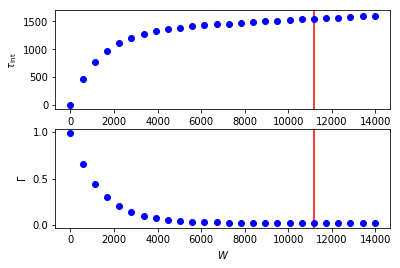

mean = -0.04642523112805757 +/- 0.002760351217976663
tau_int = 1546.3329612605385 +/- 15.166024265060866


In [26]:
mean, delta, tint, d_tint = tauint([x.T], 0, plots=True)
print ("mean = {0} +/- {1}".format(mean, delta))
print ("tau_int = {0} +/- {1}".format(tint, d_tint))

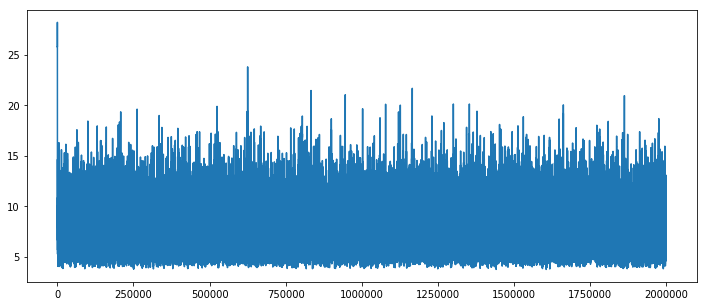

In [27]:
a = [misfit(i,Y) for i in x]
plt.figure(figsize=(12,5))
plt.plot(a[300:])

In [12]:
%%time
p = MHpcnrw(20000, s, pCNRW, misfit, 0.001, Y)

14683
Wall time: 1min 35s


In [51]:
def MHpcnrwint(niter, start, proposal, pdf, t, y):
    
    # Generate initial point & data matrix
    naccept = 0
    counter = 0
    x = [0]*niter
    x[0] = start
    a = (2 - t)/(2 + t)
    Ir = np.eye(200)
    H = np.zeros((200,200))
    ac = (np.kron(A.T,C)).T
    rarg = (np.kron(RA,RG)).T
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,a,Ir)

        nbefore = pdf(current,y)
        nafter = pdf(proposed,y)
        counter += 1
            
        k = min([1,np.exp(nbefore - nafter)])
        u = np.random.uniform()
        
        if (u<k):
            x[i] = proposed
            
        else:
            x[i] = current
            
        if ((i%50)==0):
                BT = (np.exp(RG@(proposed.reshape((4,50)))@RA.T + Umean.T)).flatten()
                jac = -(np.diag(np.exp(-ac@BT)))@ac@np.diag(BT)@rarg
                add = ((np.conj(jac.T))@jac)*100
                H = H + add
                naccept += 1
            
    print(naccept)
    print(counter)
    return np.array(x), (H/counter)

In [ ]:
%%time
l = MHpcnrwint(2601, s, pCNRW, misfit, 0.01, Y)

In [ ]:
np.save('hessiangomos50', l[1])

In [13]:
hess2 = np.load('hessiangomos50.npy')

In [28]:
hess = np.load('hessiangomos.npy')

In [14]:
def MHtestli(niter, start, proposal, pdf, t, forward,H,y):
    
    # Define synthetic data
    A,B = forli(H,t)
    
    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,A,B)

        A = min([1,np.exp(pdf(current,y) - pdf(proposed,y))])
        u = np.random.uniform()

        if (u<A):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x),y

In [23]:
def MHtestliwithup(niter, start, proposal, pdf, t, forward,H,y):
    
    ac = (np.kron(A.T,C)).T
    rarg = (np.kron(RA,RG)).T
    # Define synthetic data
    j,B = forli(H,t)
    a = (2 - t)/(2 + t)
    Ir = np.eye(200)
    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        
        if (i<10000):
            proposed = proposal(current,j,B)
        else:
            proposed = pCNRW(current,a,Ir)
        
        nbefore = misfit(current,y)
        nafter  = misfit(proposed,y)


        k = min([1,np.exp(nbefore - nafter)])
        u = np.random.uniform()

        if (u<k):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x),y

In [ ]:
%%time
a = MHtestliwithup(20000, s, lipriorreturn, misfit, 0.001, forwardmodel, hess2, Y)

In [ ]:
a.shape

In [ ]:
plt.figure(figsize=(12,5))
j = a[0]
plt.plot(Y[10])
plt.plot()

In [ ]:
mean, delta, tint, d_tint = tauint([a[0].T], 0, plots=True)
print ("mean = {0} +/- {1}".format(mean, delta))
print ("tau_int = {0} +/- {1}".format(tint, d_tint))

In [ ]:
a = [misfit(i,Y) for i in x]
plt.figure(figsize=(12,5))
plt.plot(a[300:])

In [26]:
np.save('100000k30', a[0])

In [ ]:
b = MHtestliwithup(200000, s, lipriorreturn, misfit, 0.01, forwardmodel, hess, Y)

In [ ]:
np.save('up100', b[0])

In [ ]:
mean, delta, tint, d_tint = tauint([b[0].T], 0, plots=True)
print ("mean = {0} +/- {1}".format(mean, delta))
print ("tau_int = {0} +/- {1}".format(tint, d_tint))

In [156]:
def forwardmodelb(x):
    x = x.reshape((4,50))
    return np.exp(RG@x@RA.T + Umean.T)

Text(0.5, 0, 'wavelength')

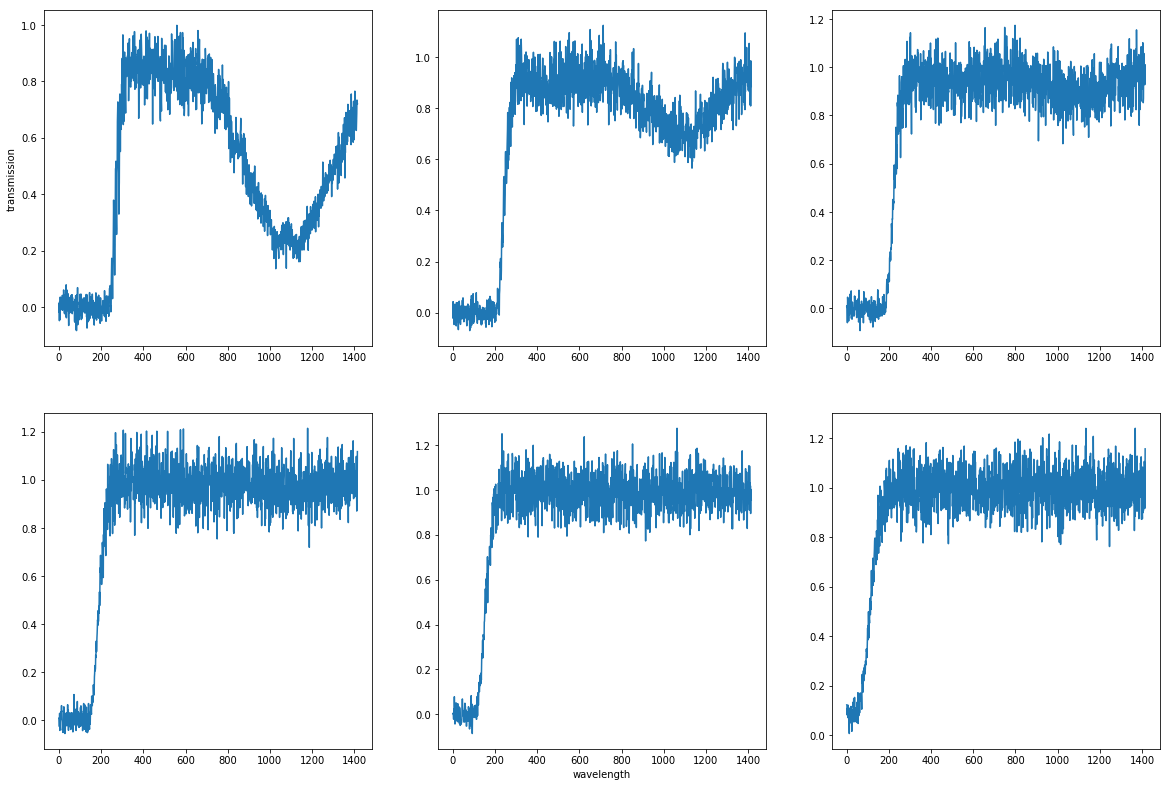

In [50]:
fig = plt.figure(figsize = (20,9.5))
fig.subplots_adjust(bottom=-.2)
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
ax1.plot(Y[0])
ax2.plot(Y[10])
ax3.plot(Y[15])
ax4.plot(Y[25])
ax5.plot(Y[35])
ax6.plot(Y[45])
ax1.set_ylabel('transmission')
ax5.set_xlabel('wavelength')

Text(0, 0.5, 'altitude(km)')

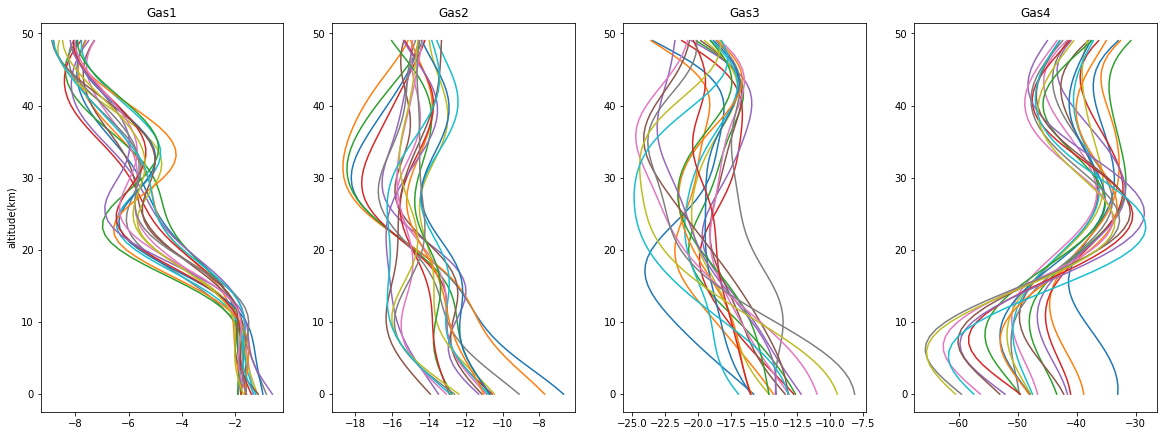

In [157]:
fig = plt.figure(figsize = (20,5))
fig.subplots_adjust(bottom=-.2)
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

for i in np.arange(0,20):
    a = forwardmodelb(x[800+10*i])
    z = np.log(a[0].T.flatten())
    ax1.plot(z,range(len(z)))

for i in np.arange(0,20):
    a = forwardmodelb(x[800+10*i])
    z = np.log(a[1].flatten())
    ax2.plot(z,range(len(z)))
    

for i in np.arange(0,20):
    a = forwardmodelb(x[800+10*i])
    z = np.log(a[2].flatten())
    ax3.plot(z,range(len(z)))

for i in np.arange(0,20):
    a = forwardmodelb(x[800+10*i])
    z = np.log(a[3].flatten())
    ax4.plot(z,range(len(z)))

ax1.title.set_text('Gas1')
ax2.title.set_text('Gas2')
ax3.title.set_text('Gas3')
ax4.title.set_text('Gas4')
ax1.set_ylabel('altitude(km)')

In [158]:
kron = np.eye(200)
l = -C.T@(forwardmodelb(x[100]))@A
(RG@kron@RA)@(l@np.exp(l))

ValueError: shapes (4,4) and (200,200) not aligned: 4 (dim 1) != 200 (dim 0)

In [ ]:
def forwardmodel(x):
    x = x.reshape((4,50))
    BT = np.exp(RG@x@RA.T + Umean.T)
    return np.exp(-C.T@BT@A)

In [48]:
ac = (np.kron(A.T,C)).T
rarg = (np.kron(RA,RG)).T
BT = (np.exp(RG@(x[100].reshape((4,50)))@RA.T + Umean.T)).flatten()

In [49]:
jac = -(np.diag(np.exp(-ac@BT)))@ac@np.diag(BT)@rarg

In [58]:
jac[1]

array([-2.64064231e-121, -6.31796057e-124, -1.55926173e-123,
       -1.04242329e-120, -2.62693042e-121, -6.28515370e-124,
       -1.55116505e-123, -1.03701037e-120, -2.58622047e-121,
       -6.18775169e-124, -1.52712640e-123, -1.02093966e-120,
       -2.51976769e-121, -6.02875779e-124, -1.48788698e-123,
       -9.94706675e-121, -2.42959254e-121, -5.81300609e-124,
       -1.43463983e-123, -9.59109017e-121, -2.31837866e-121,
       -5.54691745e-124, -1.36896962e-123, -9.15206085e-121,
       -2.18934033e-121, -5.23818233e-124, -1.29277433e-123,
       -8.64266754e-121, -2.04606850e-121, -4.89539232e-124,
       -1.20817435e-123, -8.07708585e-121, -1.89236560e-121,
       -4.52764510e-124, -1.11741497e-123, -7.47032633e-121,
       -1.73207982e-121, -4.14414780e-124, -1.02276850e-123,
       -6.83758018e-121, -1.56894870e-121, -3.75384276e-124,
       -9.26441891e-124, -6.19360171e-121, -1.40646060e-121,
       -3.36507619e-124, -8.30494976e-124, -5.55216160e-121,
       -1.24774080e-121,

In [57]:
jac[3]

array([-2.52839626e-121, -7.15965785e-124, -1.50147343e-123,
       -1.00948465e-120, -2.51526722e-121, -7.12248035e-124,
       -1.49367682e-123, -1.00424277e-120, -2.47628773e-121,
       -7.01210216e-124, -1.47052908e-123, -9.88679858e-121,
       -2.41265967e-121, -6.83192662e-124, -1.43274392e-123,
       -9.63275789e-121, -2.32631760e-121, -6.58743184e-124,
       -1.38147019e-123, -9.28802951e-121, -2.21983110e-121,
       -6.28589410e-124, -1.31823380e-123, -8.86287270e-121,
       -2.09627782e-121, -5.93602837e-124, -1.24486240e-123,
       -8.36957528e-121, -1.95909606e-121, -5.54757088e-124,
       -1.16339781e-123, -7.82186492e-121, -1.81192662e-121,
       -5.13083129e-124, -1.07600209e-123, -7.23427787e-121,
       -1.65845413e-121, -4.69624335e-124, -9.84863346e-124,
       -6.62152533e-121, -1.50225724e-121, -4.25394073e-124,
       -8.92106731e-124, -5.99789538e-121, -1.34667603e-121,
       -3.81338153e-124, -7.99715734e-124, -5.37672359e-121,
       -1.19470296e-121,

In [59]:
((np.conj(jac.T))@jac)*100

array([[2.46225443e-06, 7.24361135e-05, 1.44149211e-03, ...,
        2.19703476e-06, 1.86029435e-05, 9.48496082e-06],
       [7.24361135e-05, 2.16562542e-03, 4.35665218e-02, ...,
        6.57033133e-05, 5.62365063e-04, 2.83105922e-04],
       [1.44149211e-03, 4.35665218e-02, 9.53024033e-01, ...,
        1.32253876e-03, 1.23122098e-02, 5.93577786e-03],
       ...,
       [2.19703476e-06, 6.57033133e-05, 1.32253876e-03, ...,
        2.05939978e-06, 1.76258236e-05, 8.87457419e-06],
       [1.86029435e-05, 5.62365063e-04, 1.23122098e-02, ...,
        1.76258236e-05, 1.64065314e-04, 7.91105491e-05],
       [9.48496082e-06, 2.83105922e-04, 5.93577786e-03, ...,
        8.87457419e-06, 7.91105491e-05, 3.92269335e-05]])

In [43]:
jac

array([[-2.85281246e-267, -5.40504530e-270, -7.45500005e-270, ...,
        -2.01427292e-275, -2.77821996e-275, -1.22206921e-272],
       [-4.49344718e-268, -7.19326335e-271, -1.16759170e-270, ...,
        -2.68067977e-276, -4.35120931e-276, -1.90319009e-273],
       [-1.45055955e-270, -3.89213243e-273, -3.72201071e-273, ...,
        -1.45046277e-278, -1.38706430e-278, -6.03275624e-276],
       ...,
       [-2.21814891e-004, -4.91921858e-003, -1.00086403e-001, ...,
        -7.60308631e-005, -9.84737150e-004, -3.63159482e-004],
       [-2.20614304e-004, -4.90877740e-003, -1.00318867e-001, ...,
        -7.58694855e-005, -9.87024343e-004, -3.63339295e-004],
       [-2.19412432e-004, -4.89824734e-003, -1.00551585e-001, ...,
        -7.57067342e-005, -9.89314024e-004, -3.63518471e-004]])

In [46]:
p = (np.conj(jac.T))@(100*np.eye(70800))@jac

In [65]:
np.linalg.eig(l[1])[0]

array([ 6.72545888e+03+0.00000000e+00j,  4.19353295e+01+0.00000000e+00j,
        8.53065553e-01+0.00000000e+00j,  1.10901568e-01+0.00000000e+00j,
        4.48960235e-04+0.00000000e+00j,  2.68291894e-04+0.00000000e+00j,
        2.45675647e-05+0.00000000e+00j,  5.05305500e-06+0.00000000e+00j,
        9.75859271e-07+0.00000000e+00j,  1.18607422e-07+0.00000000e+00j,
        2.38010644e-08+0.00000000e+00j,  6.30080017e-09+0.00000000e+00j,
        3.22183196e-09+0.00000000e+00j,  2.65553546e-09+0.00000000e+00j,
        3.87441320e-10+0.00000000e+00j,  9.94008711e-11+0.00000000e+00j,
        5.28266387e-11+0.00000000e+00j,  3.68420422e-11+0.00000000e+00j,
        5.26461409e-12+0.00000000e+00j,  3.65399902e-12+0.00000000e+00j,
        1.78485724e-12+0.00000000e+00j, -1.39379735e-12+0.00000000e+00j,
       -1.03578547e-12+0.00000000e+00j,  9.22197173e-13+0.00000000e+00j,
       -6.27476518e-13+0.00000000e+00j, -4.93560522e-13+2.89919064e-13j,
       -4.93560522e-13-2.89919064e-13j,  6.35281659

In [40]:
eigenValues, eigenVectors = np.linalg.eigh(hess)
idx = eigenValues.argsort()[::-1]   
Dr = eigenValues[idx]
P = eigenVectors[:,idx]
    
Dr = [i for i in Dr if (i > 0.5)]
size = len(Dr)
P = P[0:size]
Ir = np.eye(size)

In [41]:
Dr

[6725.458876698543, 41.93532947574577, 0.8530655527969219]

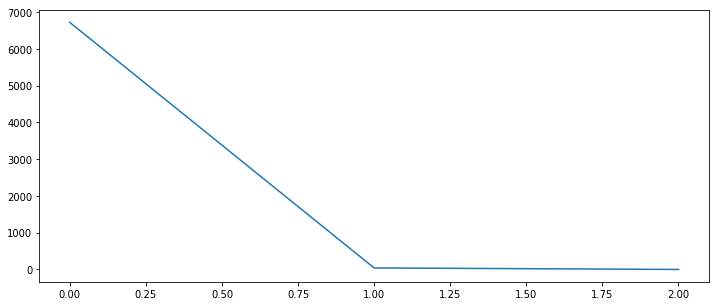

In [43]:
plt.figure(figsize=(12,5))
plt.plot(Dr)